In [1]:
import random
from PIL import Image, ImageDraw
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from sklearn import preprocessing
from skimage.exposure import histogram

im1 = io.imread("RGGB.png")
im2 = io.imread("RGGB2.png")
im3 = io.imread("BGGR.png")
im4 = io.imread("GBRG.png")
im5 = io.imread("GRBG.png")

im1C = io.imread("1.png")
im2C = io.imread("2.png")
im3C = io.imread("3.png")
im4C = io.imread("4.png")
im5C = io.imread("5.png")

def drawImage(image, title, h):
    axes[h].set_title(title)
    axes[h].imshow(image, cmap='gray')

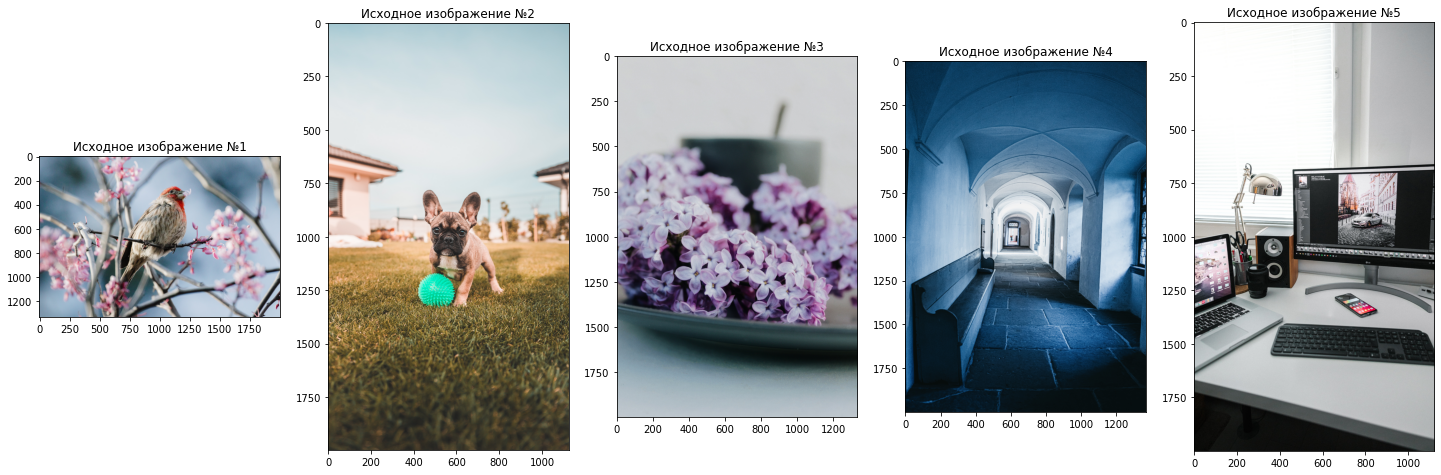

In [2]:
fig, axes = plt.subplots(1,5)
fig.set_figwidth(25) 
fig.set_figheight(10)
    
drawImage(im1C, 'Исходное изображение №1',0)
drawImage(im2C, 'Исходное изображение №2',1)
drawImage(im3C, 'Исходное изображение №3',2)
drawImage(im4C, 'Исходное изображение №4',3)
drawImage(im5C, 'Исходное изображение №5',4)


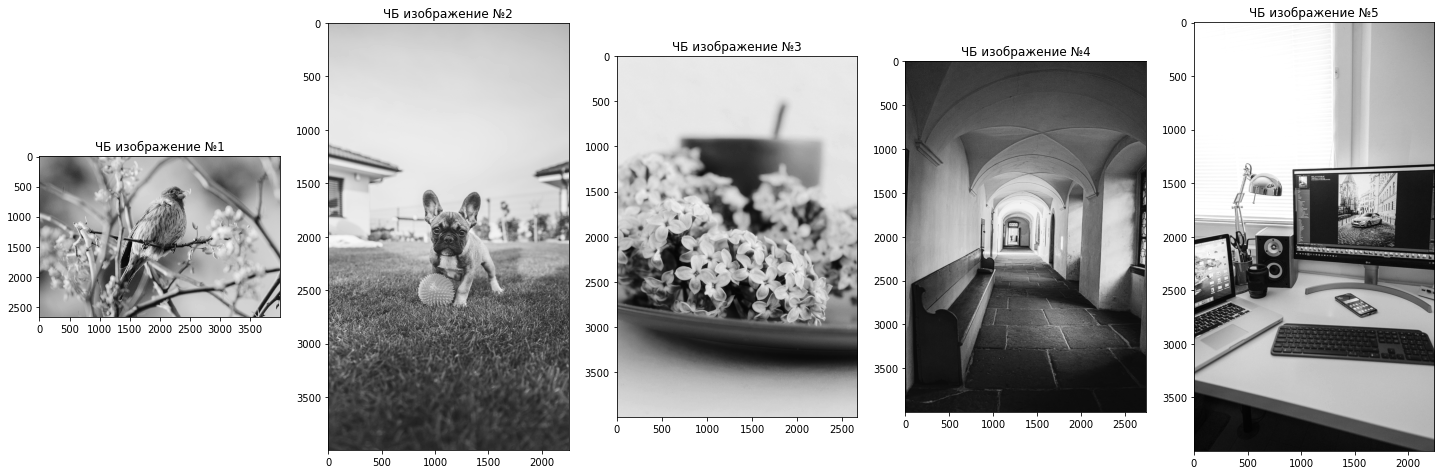

In [3]:
fig, axes = plt.subplots(1,5)
fig.set_figwidth(25) 
fig.set_figheight(10)

drawImage(im1, 'ЧБ изображение №1',0)
drawImage(im2, 'ЧБ изображение №2',1)
drawImage(im3, 'ЧБ изображение №3',2)
drawImage(im4, 'ЧБ изображение №4',3)
drawImage(im5, 'ЧБ изображение №5',4)

In [4]:
def to_RGGB(arr):
    return [arr[0], (int(arr[1]) + int(arr[2]))//2, arr[3]]

def to_BGGR(arr):
    return [arr[3], (int(arr[1]) + int(arr[2]))//2, arr[0]]

def to_GBRG(arr):
    return [arr[2], (int(arr[0]) + int(arr[3]))//2, arr[1]]

def to_GRBG(arr):
    return [arr[1], (int(arr[0]) + int(arr[3]))//2, arr[2]]

def superPixel(img, mode):
    out = np.ones((len(img) // 2, len(img[0]) // 2, 3))
    m = 0
    n = 0
    for i in range(0, len(img), 2):
        n = 0 
        for j in range(0, len(img[i]), 2):
            if i + 2 >= len(img) or j + 2 >= len(img[i]): break
            else:
                if mode == "RGGB": 
                    out[m][n] = to_RGGB(img[i:i+2, j:j+2].reshape(-1, 4)[0])
                elif mode == "BGGR":
                    out[m][n] = to_BGGR(img[i:i+2, j:j+2].reshape(-1, 4)[0])
                elif mode == "GBRG":
                    out[m][n] = to_GBRG(img[i:i+2, j:j+2].reshape(-1, 4)[0])
                elif mode == "GRBG":
                    out[m][n] = to_GRBG(img[i:i+2, j:j+2].reshape(-1, 4)[0])
                else:
                    print("Указан неверный режим работы.")
                    return 0    
            n += 1
        m += 1

    return np.int16(out)

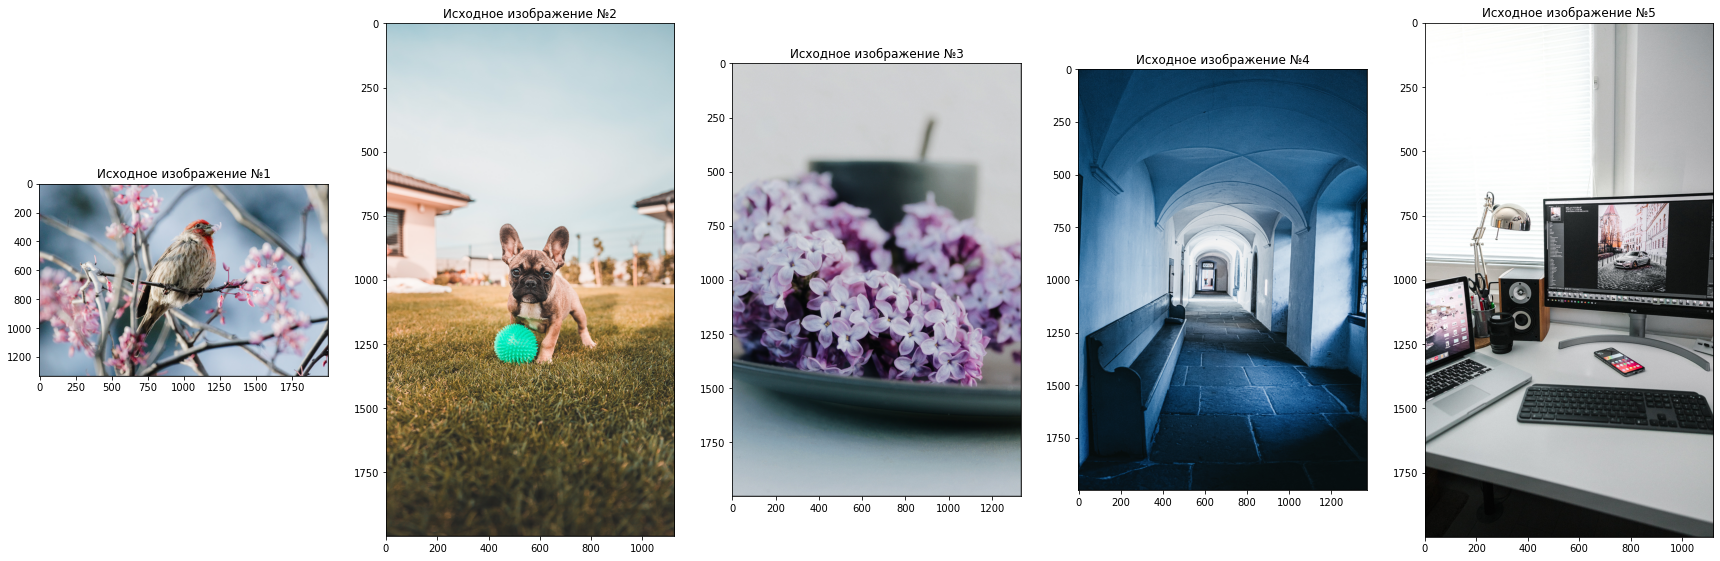

In [5]:
im1Pix = superPixel(im1, "RGGB")
im2Pix = superPixel(im2, "RGGB")
im3Pix = superPixel(im3, "BGGR")
im4Pix = superPixel(im4, "GBRG")
im5Pix = superPixel(im5, "GRBG")

fig, axes = plt.subplots(1,5)
fig.set_figwidth(30) 
fig.set_figheight(20)

drawImage(im1Pix, 'Исходное изображение №1',0)
drawImage(im2Pix, 'Исходное изображение №2',1)
drawImage(im3Pix, 'Исходное изображение №3',2)
drawImage(im4Pix, 'Исходное изображение №4',3)
drawImage(im5Pix, 'Исходное изображение №5',4)

In [6]:
def imPad(image):
    extra_col_left = [el[1] for el in [i for i in image]]
    image = np.c_[extra_col_left, image]
    image = np.r_[image[1].reshape(1, -1), image]

    extra_col_right = [el[-2] for el in [i for i in image]]
    image = np.c_[image, extra_col_right]
    image = np.r_[image, image[-2].reshape(1, -1)]

    image[0][0] = image[2][2]
    image[0][-1] = image[2][-3]
    image[-1][-1] = image[-3][-3]
    image[-1][0] = image[-3][2]

    return image
    

def R_(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 4
    
    #R
    R = gray_image[target_y][target_x]

    #G
    G = 0
    G += gray_image[target_y][target_x - 1]
    G += gray_image[target_y - 1][target_x]
    G += gray_image[target_y][target_x + 1]
    G += gray_image[target_y + 1][target_x]
    G = int(G / delit)

    #B
    B = 0
    B += gray_image[target_y - 1][target_x - 1]
    B += gray_image[target_y - 1][target_x + 1]
    B += gray_image[target_y + 1][target_x + 1]
    B += gray_image[target_y + 1][target_x - 1]
    B = int(B / delit)
    
    return R, G, B


def G_first(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 2
    
    #G
    G = gray_image[target_y][target_x]
    
    #R
    R = 0
    R += gray_image[target_y][target_x - 1]
    R += gray_image[target_y][target_x + 1]
    R = int(R / delit)
    
    #B
    B = 0
    B += gray_image[target_y - 1][target_x]
    B += gray_image[target_y + 1][target_x]
    B = int(B / delit)
    return R, G, B


def G_second(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 2
    
    #G
    G = gray_image[target_y][target_x]
    
    #R
    R = 0
    R += gray_image[target_y - 1][target_x]
    R += gray_image[target_y + 1][target_x]
    R = int(R / delit)
    
    #B
    B = 0
    B += gray_image[target_y][target_x - 1]
    B += gray_image[target_y][target_x + 1]
    B = int(B / delit)
    return R, G, B

def B_(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 4
    
    #B
    B = gray_image[target_y][target_x]
    
    #G
    G = 0
    G += gray_image[target_y][target_x - 1]
    G += gray_image[target_y - 1][target_x]
    G += gray_image[target_y][target_x + 1]
    G += gray_image[target_y + 1][target_x]
    G = int(G / delit)

    #R
    R = 0
    R += gray_image[target_y - 1][target_x - 1]
    R += gray_image[target_y - 1][target_x + 1]
    R += gray_image[target_y + 1][target_x + 1]
    R += gray_image[target_y + 1][target_x - 1]
    R = int(R / delit)

    return R, G, B
    
def bilinear_interpolation(image):
    color_image = []

    for rows_ind in range(len(image[1:-1])):
        if rows_ind % 2 == 0:
            first_row = []

            for cols_ind in range(len(image[rows_ind + 1][1:-1])):
                RGB = { 'r': 0, 'g': 0, 'b': 0 }
                if cols_ind % 2 == 0:
                    RGB['r'], RGB['g'], RGB['b'] = R_(image, rows_ind + 1, cols_ind + 1)
                    first_row.append(list(RGB.values()))
                    continue
                RGB['r'], RGB['g'], RGB['b'] = G_first(image, rows_ind + 1, cols_ind + 1)
                first_row.append(list(RGB.values()))
            color_image.append(first_row)
            continue
            
        second_row = []

        for cols_ind in range(len(image[rows_ind + 1][1:-1])):
            RGB = { 'r': 0, 'g': 0, 'b': 0 }
            if cols_ind % 2 == 0:
                RGB['r'], RGB['g'], RGB['b'] = G_second(image, rows_ind + 1, cols_ind + 1)
                second_row.append(list(RGB.values()))
                continue
            RGB['r'], RGB['g'], RGB['b'] = B_(image, rows_ind + 1, cols_ind + 1)
            second_row.append(list(RGB.values()))   
        color_image.append(second_row)

    return np.array(color_image)
  

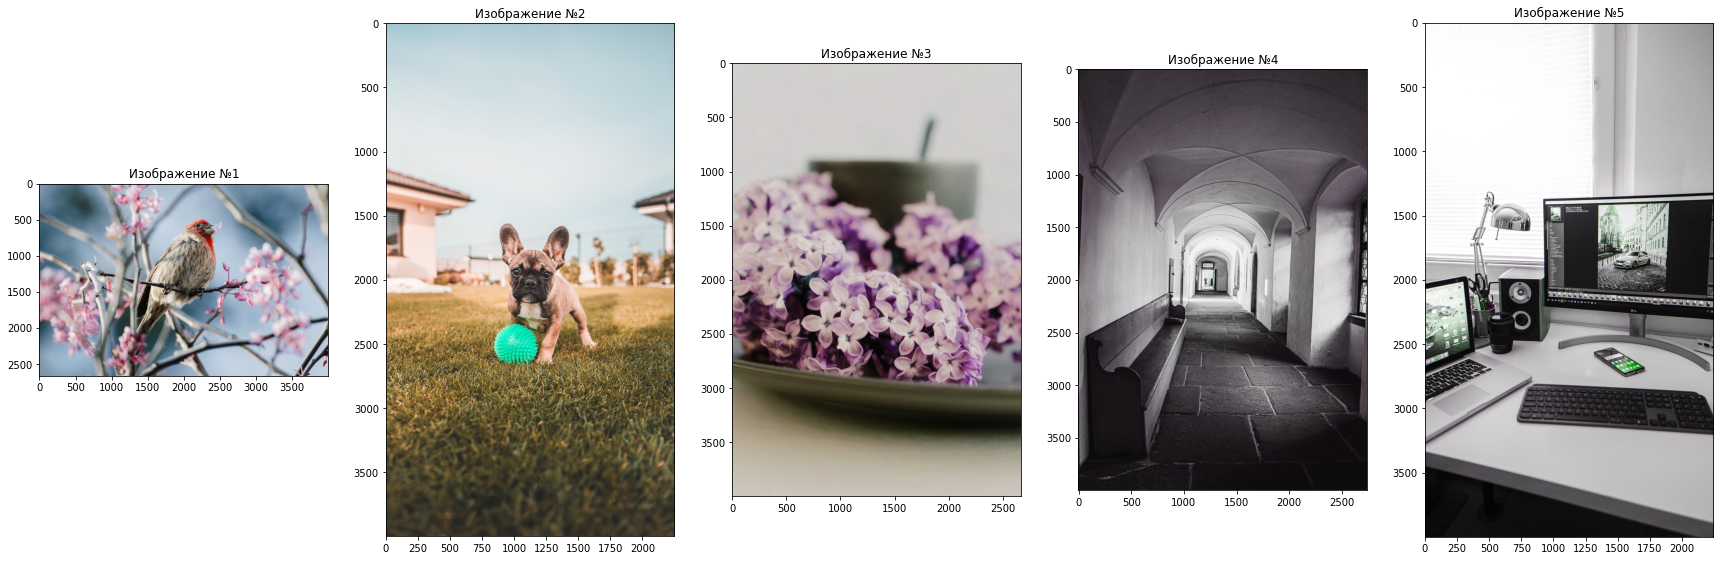

In [7]:
im1BI = bilinear_interpolation(imPad(im1))
im2BI = bilinear_interpolation(imPad(im2))
im3BI = bilinear_interpolation(imPad(im3))
im4BI = bilinear_interpolation(imPad(im4))
im5BI = bilinear_interpolation(imPad(im5))


fig, axes = plt.subplots(1,5)
fig.set_figwidth(30) 
fig.set_figheight(20)

drawImage(im1BI, 'Изображение №1',0)
drawImage(im2BI, 'Изображение №2',1)
drawImage(im3BI, 'Изображение №3',2)
drawImage(im4BI, 'Изображение №4',3)
drawImage(im5BI, 'Изображение №5',4)